In [1]:
!pip install concise

     |████████████████████████████████| 1.3MB 4.6MB/s 
     |████████████████████████████████| 317kB 20.8MB/s 
  Created wheel for gtfparse: filename=gtfparse-1.2.0-cp36-none-any.whl size=11883 sha256=4540b1a2333198f370eb1b26a659d0b0d0913ba28ce433b626398b1e34419ace
  Stored in directory: /root/.cache/pip/wheels/c4/27/96/6ba6fe28cbb162c326823553e3e45ac502160d1340566360f8
Successfully built gtfparse
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [3]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import sys

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold

# tf.python.control_flow_ops = tf


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K

import matplotlib as mpl

mpl.use('Agg')
# from keras.utils.layer_utils import print_layer_shapes

import utils
sys.path.append(".")
from utils import load_data_merged
import plotseqlogo
import IntegratedGradients
from plotseqlogo import *
from IntegratedGradients import *
from utils import *

from tensorflow.python.keras.backend import set_session
from matplotlib.lines import Line2D   

model_path = "./models/final.h5"

CLASS_PARTIAL_LOSS = 0
CLASS_COMPLETELY_LOSS = 1 
%matplotlib inline



TensorFlow 1.x selected.


Using TensorFlow backend.
2020-05-18 11:44:10,193 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2020-05-18 11:44:10,220 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


2020-05-18 11:44:10,438 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/gdrive/My Drive/nn/plotseqlogo.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/gdrive/My Drive/nn/plotseqlogo.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [0]:
_, _, _, _, x_test_seq, y_test = load_data_merged(r"dataset/solo_test_with_crc10_var_0.05.pkl", 150, False)

In [0]:
import re
ss_re = re.compile("[CG]CG[CG]")
ww_re = re.compile("[AT]CG[AT]")

In [0]:
def vecs2dna(seq_vecs):
    seqs = []
    # seq_vecs = np.reshape(seq_vecs, (seq_vecs.shape[0], 4, -1))
    for i in range(seq_vecs.shape[0]):
        seq_list = [''] * seq_vecs.shape[1]
        for j in range(seq_vecs.shape[1]):
            if seq_vecs[i, j,0] > 0:
                seq_list[j] = 'A'
            elif seq_vecs[i, j, 1] >0:
                seq_list[j] = 'C'
            elif seq_vecs[i, j, 2] >0:
                seq_list[j] = 'G'
            elif seq_vecs[i, j, 3] >0 :
                seq_list[j] = 'T'
            else:
                print("problem")

        seqs.append(''.join(seq_list))

    return seqs

def get_ex_ind(predict_label, thr=0.5, with_pred=False):

  sess = tf.Session()
  tf.random.set_random_seed(5005)
  K.set_session(sess)

  session = K.get_session()
  init = tf.global_variables_initializer()
  session.run(init)

  with session.as_default():
      with session:
        model = load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN })
        pred = model.predict(x_test_seq)
        ind= []

        if predict_label ==CLASS_PARTIAL_LOSS:
          pred = 1 - pred

        for i in sorted(enumerate(pred), key=lambda x:x[1],reverse=True):
          if y_test[i[0]]==predict_label and pred[i[0]] > thr:
            ind.append(i[0])
  
  if with_pred:
    return ind, pred[ind]
  
  else:
    return ind

def get_prediction(data):

  sess = tf.Session()
  tf.random.set_random_seed(5005)
  K.set_session(sess)

  session = K.get_session()
  init = tf.global_variables_initializer()
  session.run(init)

  with session.as_default():
      with session:

        model = load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN })
        pred = model.predict(data)

  return pred

In [0]:
def get_refrence_list_zeros_flank_1(seq_example):
    rf = np.zeros(seq_example.shape)
    m = int(seq_example.shape[0]/ 2 - 1)
    for i in range(-2,2):
      rf[m-i] = seq_example[m-i]
    return rf

def get_ex_seq(data, predict_label, number_of_seq, thr=0.5):

  sess = tf.Session()
  tf.random.set_random_seed(5005)
  K.set_session(sess)

  session = K.get_session()
  init = tf.global_variables_initializer()
  session.run(init)

  with session.as_default():
      with session:
        model = load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN })
        pred = model.predict(data)
        ind= []

        if predict_label ==CLASS_PARTIAL_LOSS:
          pred = 1 - pred

        for i in sorted(enumerate(pred), key=lambda x:x[1],reverse=True):
          if y_test[i[0]]==predict_label and pred[i[0]] > thr:
            ind.append(i[0])
        
        if number_of_seq != -1:
          ind = ind[:number_of_seq]
        
        gradients = integrated_gradients(model) 
        ex_seq=np.array([gradients.explain([x_test_seq[i]],reference=[get_refrence_list_zeros_flank_1(x_test_seq[i])],num_steps=100)[0] for i in ind])

        if predict_label == CLASS_PARTIAL_LOSS:
          ex_seq = ex_seq * -1
  
  return ex_seq

PL changing flanks

In [8]:
pl_ind = get_ex_ind(CLASS_PARTIAL_LOSS,thr=0.5)
pl_array = np.array([x_test_seq[i] for i in pl_ind])
pl_seq = vecs2dna(pl_array)

ccgc = []
ccgg = []
gcgc = []
gcgg = []

for seq in pl_seq:
  if "CCGC" in seq:
    ccgc.append(seq)
  elif "CCGG" in seq:
    ccgg.append(seq)
  elif "GCGG" in seq:
    gcgg.append(seq)
  elif "GCGC" in seq:
    gcgc.append(seq)
  else:
    pass

2020-05-18 11:17:19,623 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2020-05-18 11:17:19,625 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-05-18 11:17:19,715 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-05-18 11:17:19,718 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-05-18 11:17:19,762 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-05-18 11:17:27,175 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def calculate_flank_changes_ss_to_ww(seq_list, original_seq, first=True):
  original_seq = original_seq.upper()
  seq_array = np.array([seq_to_mat(i) for i in seq_list])
  original_pred = 1 - get_prediction(seq_array)
  d = {original_seq:original_pred}
  
  letters = ["A","C","G","T"]
  if first:
    letters.remove(original_seq[0])
  else:
    letters.remove(original_seq[-1])
  for letter in letters:
    if first:
      new_flank = letter+ original_seq[1:]
    else:
      new_flank = original_seq[:-1] + letter

    new_seq = [seq.replace(original_seq, new_flank) for seq in seq_list]  
    new_array = np.array([seq_to_mat(i) for i in new_seq])
    new_pred = 1 - get_prediction(new_array)
    d[new_flank] = new_pred
        
  return d

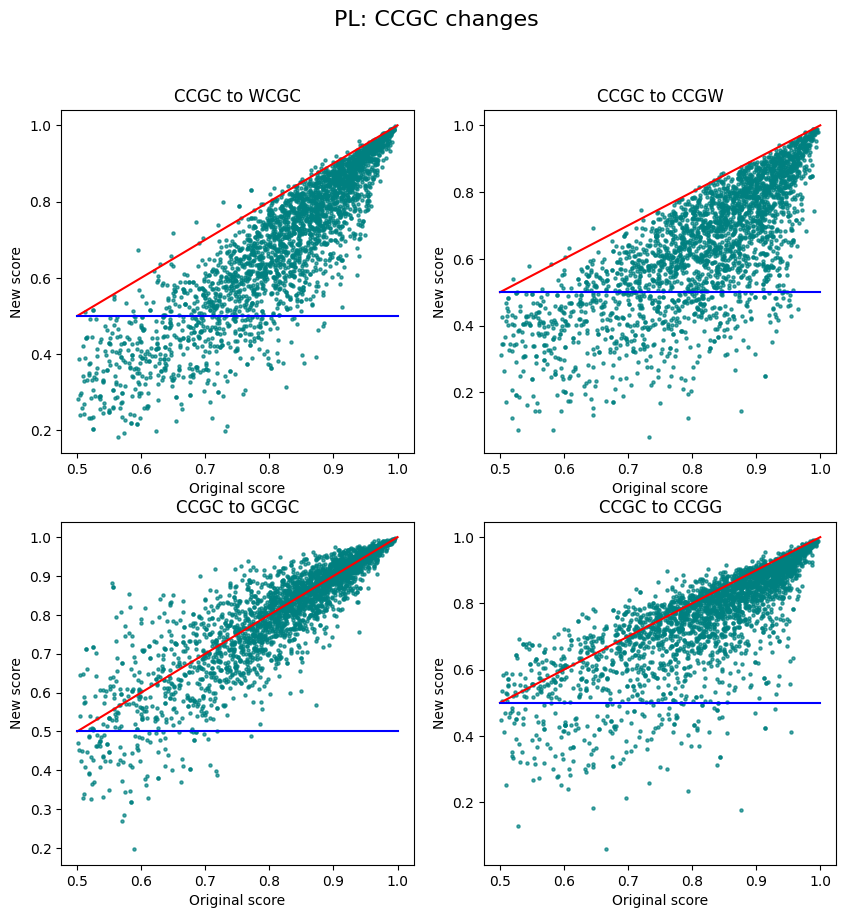

In [58]:
# CCGC
original_flank = "CCGC"
dict_first = calculate_flank_changes_ss_to_ww(ccgc, original_flank)
dict_last = calculate_flank_changes_ss_to_ww(ccgc, original_flank,False)

fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = dict_first["ACGC"] + dict_first["TCGC"]
a = a / 2
plt.scatter(x=dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to WCGC" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=dict_first[original_flank], y=dict_first["GCGC"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "GCGC"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = dict_last["CCGA"] + dict_last["CCGT"]
a = a / 2
plt.scatter(x=dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to CCGW" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=dict_last[original_flank], y=dict_last["CCGG"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "CCGG"))
plt.xlabel("Original score")
plt.ylabel("New score")


fig.suptitle('PL: %s changes' % original_flank, fontsize=16)
fig.savefig("./pl_%s_changes_prediction.png" %original_flank)  
plt.show()
plt.close()

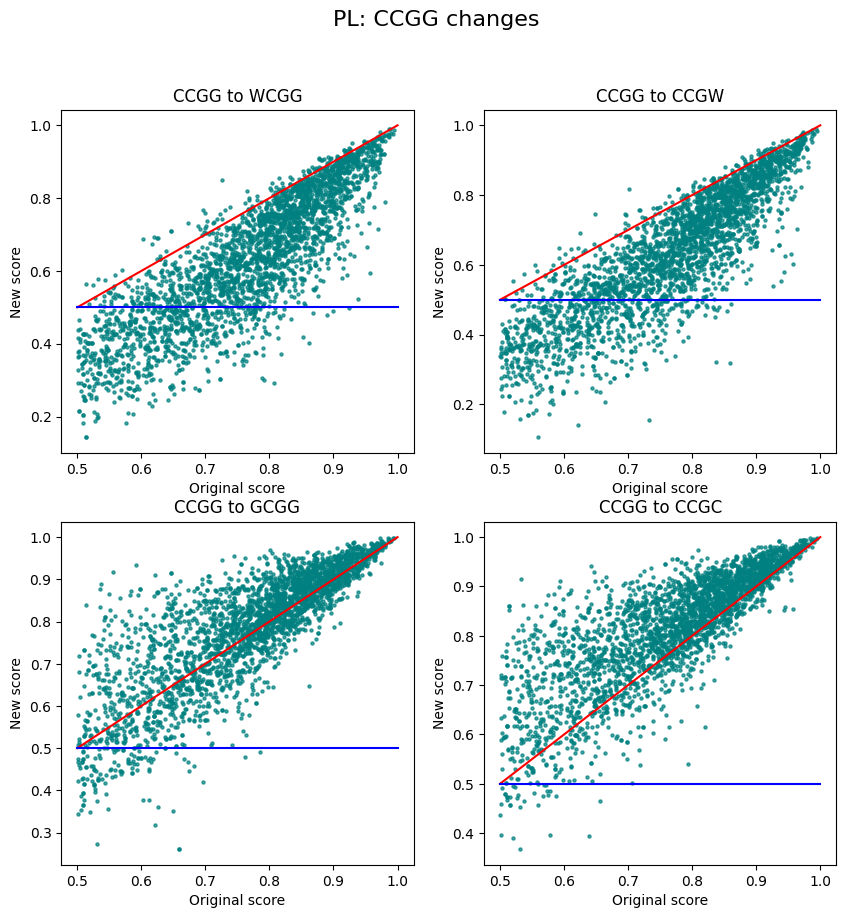

In [59]:
# CCGG
original_flank = "CCGG"
dict_first = calculate_flank_changes_ss_to_ww(ccgg, original_flank)
dict_last = calculate_flank_changes_ss_to_ww(ccgg, original_flank,False)

fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = dict_first["ACGG"] + dict_first["TCGG"]
a = a / 2
plt.scatter(x=dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to WCGG" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=dict_first[original_flank], y=dict_first["GCGG"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "GCGG"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = dict_last["CCGA"] + dict_last["CCGT"]
a = a / 2
plt.scatter(x=dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to CCGW" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=dict_last[original_flank], y=dict_last["CCGC"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "CCGC"))
plt.xlabel("Original score")
plt.ylabel("New score")


fig.suptitle('PL: %s changes' % original_flank, fontsize=16)
fig.savefig("./pl_%s_changes_prediction.png" %original_flank)  
plt.show()
plt.close()

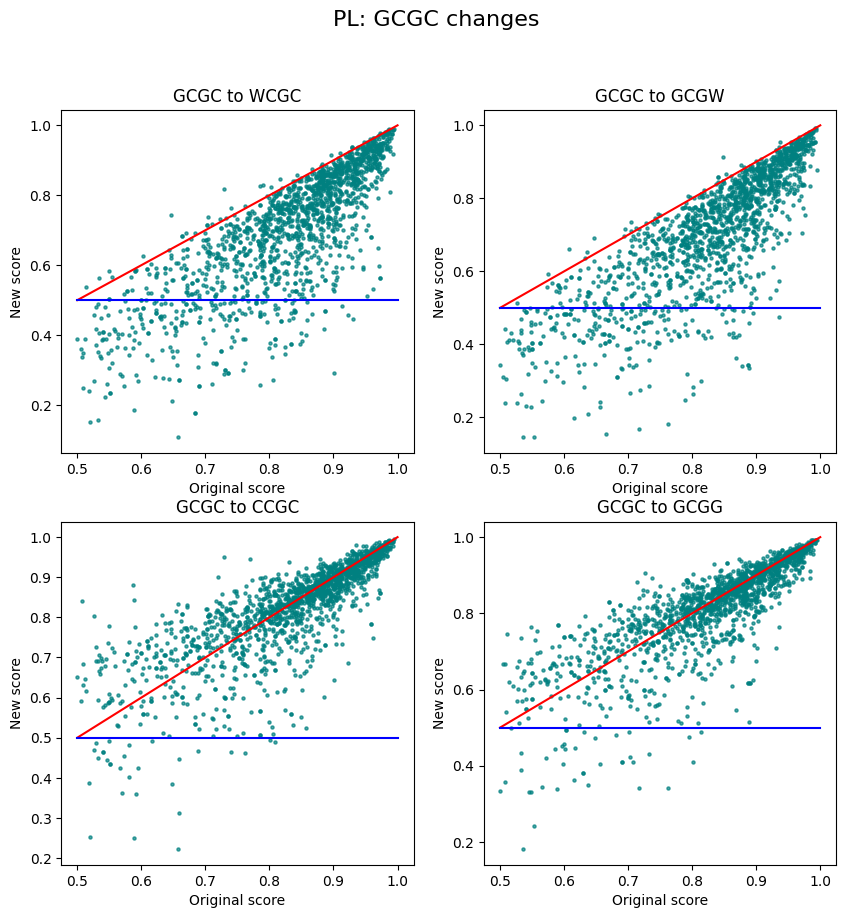

In [60]:
# GCGC
original_flank = "GCGC"
dict_first = calculate_flank_changes_ss_to_ww(gcgc, original_flank)
dict_last = calculate_flank_changes_ss_to_ww(gcgc, original_flank,False)

fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = dict_first["ACGC"] + dict_first["TCGC"]
a = a / 2
plt.scatter(x=dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to WCGC" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=dict_first[original_flank], y=dict_first["CCGC"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "CCGC"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = dict_last["GCGA"] + dict_last["GCGT"]
a = a / 2
plt.scatter(x=dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to GCGW" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=dict_last[original_flank], y=dict_last["GCGG"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "GCGG"))
plt.xlabel("Original score")
plt.ylabel("New score")


fig.suptitle('PL: %s changes' % original_flank, fontsize=16)
fig.savefig("./pl_%s_changes_prediction.png" %original_flank)  
plt.show()
plt.close()

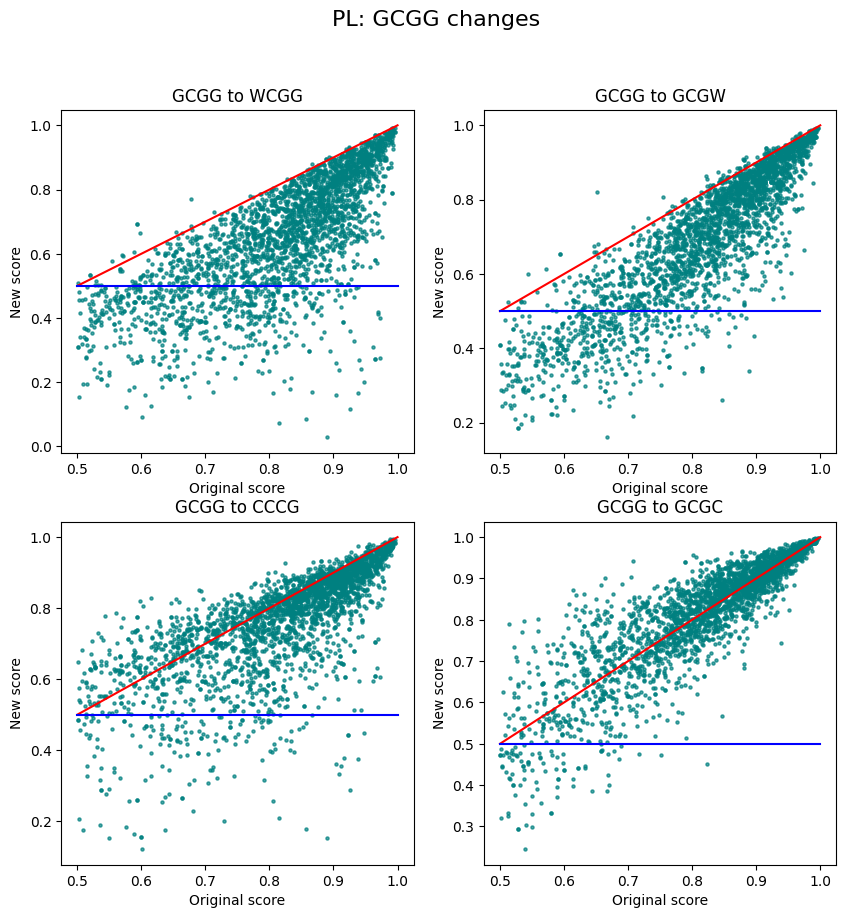

In [19]:
# GCGG
original_flank = "GCGG"
dict_first = calculate_flank_changes_ss_to_ww(gcgg, original_flank)
dict_last = calculate_flank_changes_ss_to_ww(gcgg, original_flank,False)

fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = dict_first["ACGG"] + dict_first["TCGG"]
a = a / 2
plt.scatter(x=dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to WCGG" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=dict_first[original_flank], y=dict_first["CCGG"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "CCCG"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = dict_last["GCGA"] + dict_last["GCGT"]
a = a / 2
plt.scatter(x=dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to GCGW" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=dict_last[original_flank], y=dict_last["GCGC"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "GCGC"))
plt.xlabel("Original score")
plt.ylabel("New score")

fig.suptitle('PL: %s changes' % original_flank, fontsize=16)
fig.savefig("./pl_%s_changes_prediction.png" %original_flank)  
plt.show()
plt.close()

PL WCGW to SCGS

In [8]:
cl_ind = get_ex_ind(CLASS_PARTIAL_LOSS,thr=0.5)
cl_array = np.array([x_test_seq[i] for i in cl_ind])
cl_seq = vecs2dna(cl_array)

acga = []
acgt = []
tcgt = []
tcga = []

for seq in cl_seq:
  if "ACGA" in seq:
    acga.append(seq)
  elif "ACGT" in seq:
    acgt.append(seq)
  elif "TCGT" in seq:
    tcgt.append(seq)
  elif "TCGA" in seq:
    tcga.append(seq)
  else:
    pass

2020-05-18 11:45:41,267 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2020-05-18 11:45:41,269 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-05-18 11:45:41,303 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-05-18 11:45:41,305 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-05-18 11:45:41,339 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-05-18 11:45:42,249 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


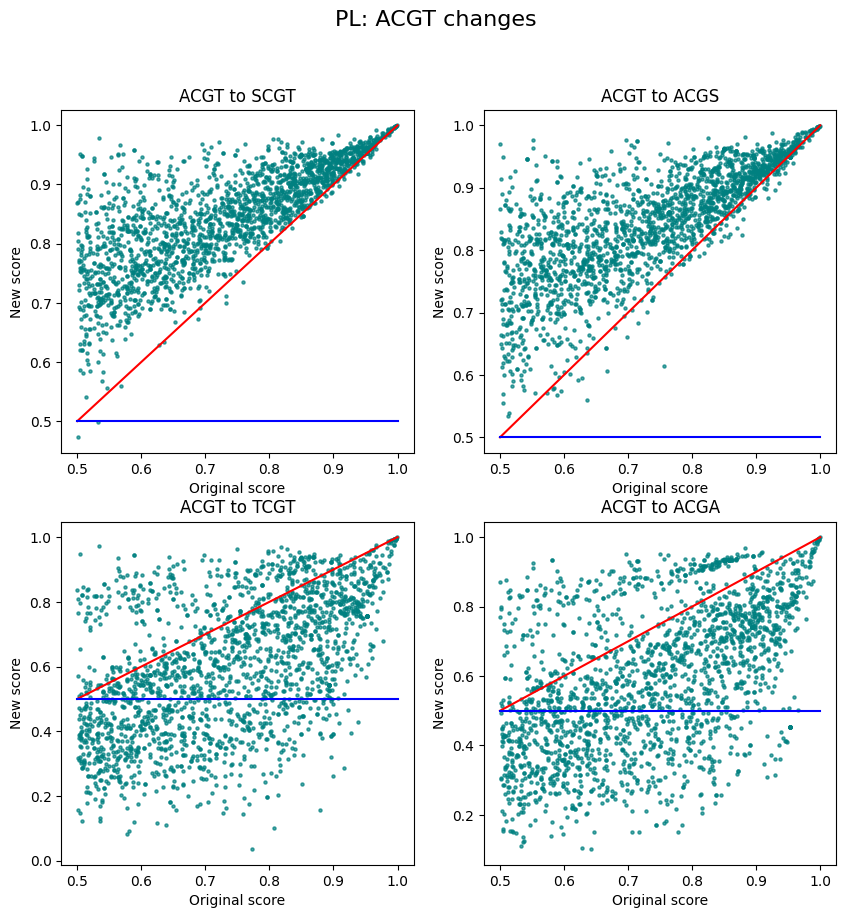

In [9]:
# ACGT
original_flank = "ACGT"
acgt_dict_first = calculate_flank_changes_ss_to_ww(acgt, original_flank)
acgt_dict_last = calculate_flank_changes_ss_to_ww(acgt, original_flank,False)

fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acgt_dict_first["GCGT"] + acgt_dict_first["CCGT"]
a = a / 2
plt.scatter(x=acgt_dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("ACGT to SCGT")

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acgt_dict_first[original_flank], y=acgt_dict_first["TCGT"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGT"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acgt_dict_last["ACGG"] + acgt_dict_last["ACGC"]
a = a / 2
plt.scatter(x=acgt_dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("ACGT to ACGS")

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acgt_dict_last[original_flank], y=acgt_dict_last["ACGA"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "ACGA"))
plt.xlabel("Original score")
plt.ylabel("New score")

fig.suptitle('PL: %s changes' % original_flank, fontsize=16)
fig.savefig("./pl_%s_changes_prediction.png" %original_flank)
plt.show()
plt.close()


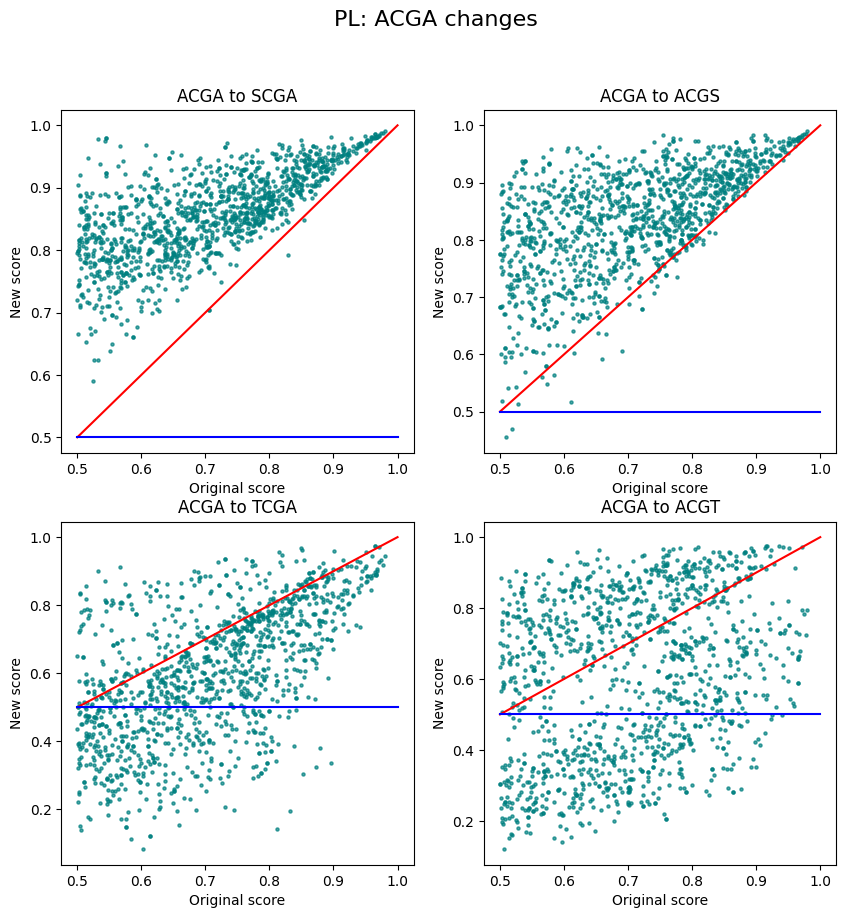

In [10]:
original_flank = "ACGA"
acga_dict_first = calculate_flank_changes_ss_to_ww(acga, original_flank)
acga_dict_last = calculate_flank_changes_ss_to_ww(acga, original_flank, False)
fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acga_dict_first["GCGA"] + acga_dict_first["CCGA"]
a = a / 2
plt.scatter(x=acga_dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to SCGA" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acga_dict_first[original_flank], y=acga_dict_first["TCGA"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGA"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acga_dict_last["ACGG"] + acga_dict_last["ACGC"]
a = a / 2
plt.scatter(x=acga_dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to ACGS" % original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acga_dict_last[original_flank], y=acga_dict_last["ACGT"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "ACGT"))
plt.xlabel("Original score")
plt.ylabel("New score")


fig.suptitle('PL: %s changes' % original_flank, fontsize=16)
fig.savefig("./pl_%s_changes_prediction.png" %original_flank)
plt.show()
plt.close()

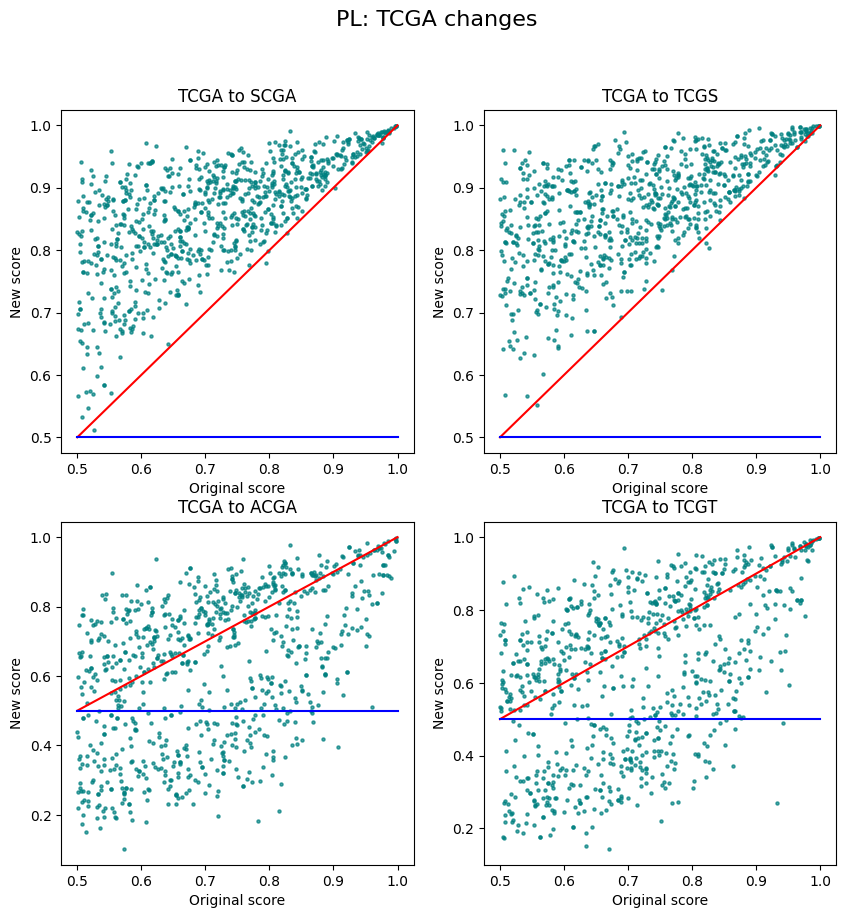

In [11]:
original_flank = "TCGA"
tcga_dict_first = calculate_flank_changes_ss_to_ww(tcga, original_flank)
tcga_dict_last = calculate_flank_changes_ss_to_ww(tcga, original_flank, False)
fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = tcga_dict_first["GCGA"] + tcga_dict_first["CCGA"]
a = a / 2
plt.scatter(x=tcga_dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to SCGA" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=tcga_dict_first[original_flank], y=tcga_dict_first["ACGA"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "ACGA"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = tcga_dict_last["TCGG"] + tcga_dict_last["TCGC"]
a = a / 2
plt.scatter(x=tcga_dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to TCGS" % original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=tcga_dict_last[original_flank], y=tcga_dict_last["TCGT"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGT"))
plt.xlabel("Original score")
plt.ylabel("New score")


fig.suptitle('PL: %s changes' % original_flank, fontsize=16)
fig.savefig("./pl_%s_changes_prediction.png" %original_flank)
plt.show()
plt.close()

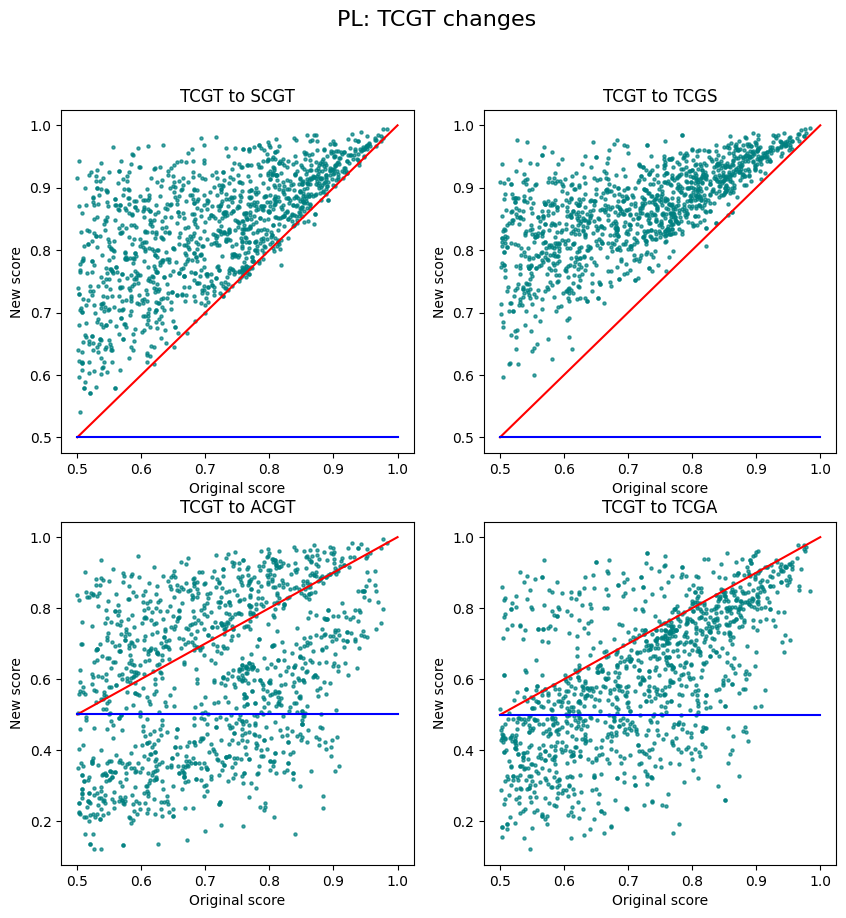

In [13]:
original_flank = "TCGT"
tcgt_dict_first = calculate_flank_changes_ss_to_ww(tcgt, original_flank)
tcgt_dict_last = calculate_flank_changes_ss_to_ww(tcgt, original_flank, False)

fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = tcgt_dict_first["GCGT"] + tcgt_dict_first["CCGT"]
a = a / 2
plt.scatter(x=tcgt_dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to SCGT" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=tcgt_dict_first[original_flank], y=tcgt_dict_first["ACGT"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "ACGT"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = tcgt_dict_last["TCGG"] + tcgt_dict_last["TCGC"]
a = a / 2
plt.scatter(x=tcgt_dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to TCGS" % original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=tcgt_dict_last[original_flank], y=tcgt_dict_last["TCGA"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGA"))
plt.xlabel("Original score")
plt.ylabel("New score")


fig.suptitle('PL: %s changes' % original_flank, fontsize=16)
fig.savefig("./pl_%s_changes_prediction.png" %original_flank)
plt.show()
plt.close()

CL changing flanks

In [0]:
cl_ind = get_ex_ind(CLASS_COMPLETELY_LOSS,thr=0.5)
cl_array = np.array([x_test_seq[i] for i in cl_ind])
cl_seq = vecs2dna(cl_array)

acga = []
acgt = []
tcgt = []
tcga = []

for seq in cl_seq:
  if "ACGA" in seq:
    acga.append(seq)
  elif "ACGT" in seq:
    acgt.append(seq)
  elif "TCGT" in seq:
    tcgt.append(seq)
  elif "TCGA" in seq:
    tcga.append(seq)
  else:
    pass

In [0]:
def calculate_flank_changes_ww_to_ss(seq_list, original_seq, first=True):
  original_seq = original_seq.upper()
  seq_array = np.array([seq_to_mat(i) for i in seq_list])
  original_pred = get_prediction(seq_array)
  d = {original_seq:original_pred}
  
  letters = ["A","C","G","T"]
  if first:
    letters.remove(original_seq[0])
  else:
    letters.remove(original_seq[-1])
  for letter in letters:
    if first:
      new_flank = letter+ original_seq[1:]
    else:
      new_flank = original_seq[:-1] + letter

    new_seq = [seq.replace(original_seq, new_flank) for seq in seq_list]  
    new_array = np.array([seq_to_mat(i) for i in new_seq])
    new_pred = get_prediction(new_array)
    d[new_flank] = new_pred
        
  return d

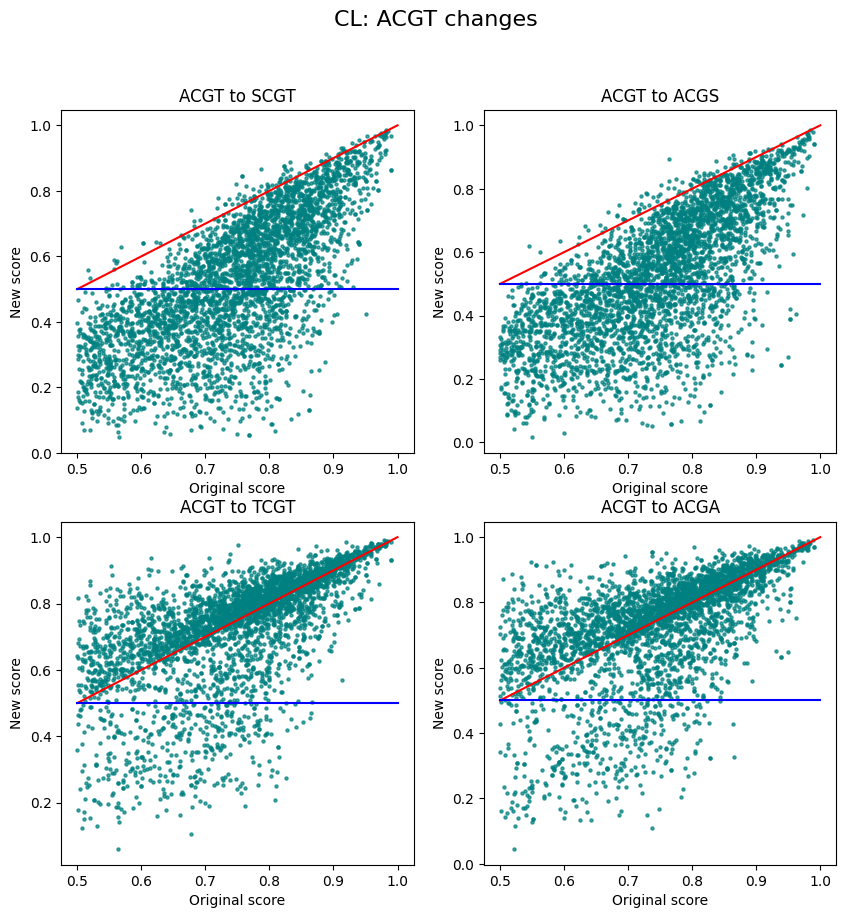

In [16]:
# ACGT
original_flank = "ACGT"
acgt_dict_first = calculate_flank_changes_ww_to_ss(acgt, original_flank)
acgt_dict_last = calculate_flank_changes_ww_to_ss(acgt, original_flank,False)

fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acgt_dict_first["GCGT"] + acgt_dict_first["CCGT"]
a = a / 2
plt.scatter(x=acgt_dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("ACGT to SCGT")

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acgt_dict_first[original_flank], y=acgt_dict_first["TCGT"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGT"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acgt_dict_last["ACGG"] + acgt_dict_last["ACGC"]
a = a / 2
plt.scatter(x=acgt_dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("ACGT to ACGS")

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acgt_dict_last[original_flank], y=acgt_dict_last["ACGA"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "ACGA"))
plt.xlabel("Original score")
plt.ylabel("New score")

fig.suptitle('CL: %s changes' % original_flank, fontsize=16)
fig.savefig("./cl_%s_changes_prediction.png" %original_flank)
plt.show()
plt.close()


In [0]:
fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acgt_dict_first["GCGT"] + acgt_dict_first["CCGT"]
a = a / 2
plt.scatter(x=acgt_dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("ACGT to SCGT")

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acgt_dict_first[original_flank], y=acgt_dict_first["TCGT"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGT"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acgt_dict_last["ACGG"] + acgt_dict_last["ACGC"]
a = a / 2
plt.scatter(x=acgt_dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("ACGT to ACGS")

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acgt_dict_last[original_flank], y=acgt_dict_last["ACGA"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "ACGA"))
plt.xlabel("Original score")
plt.ylabel("New score")

fig.suptitle('CL: %s changes' % original_flank, fontsize=16)
fig.savefig("./cl_%s_changes_prediction.png" %original_flank)
plt.show()
plt.close()

In [0]:
original_flank = "ACGA"
acga_dict_first = calculate_flank_changes_ww_to_ss(acga, original_flank)
acga_dict_last = calculate_flank_changes_ww_to_ss(acga, original_flank, False)

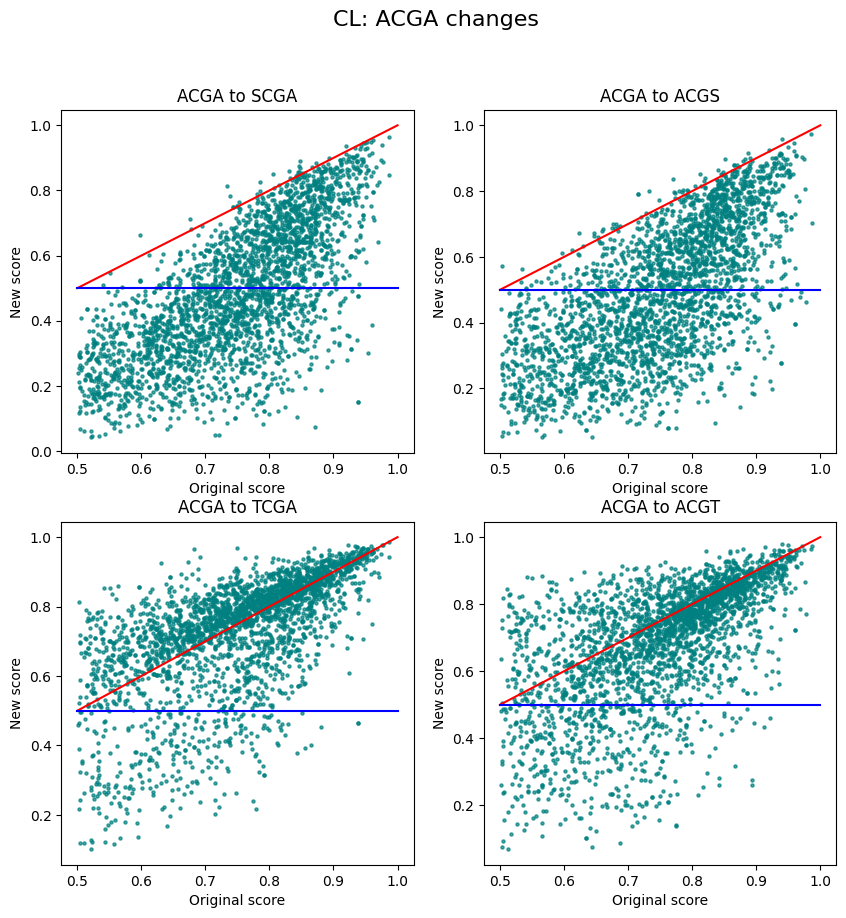

In [53]:
fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acga_dict_first["GCGA"] + acga_dict_first["CCGA"]
a = a / 2
plt.scatter(x=acga_dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to SCGA" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acga_dict_first[original_flank], y=acga_dict_first["TCGA"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGA"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = acga_dict_last["ACGG"] + acga_dict_last["ACGC"]
a = a / 2
plt.scatter(x=acga_dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to ACGS" % original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=acga_dict_last[original_flank], y=acga_dict_last["ACGT"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "ACGT"))
plt.xlabel("Original score")
plt.ylabel("New score")


fig.suptitle('CL: %s changes' % original_flank, fontsize=16)
fig.savefig("./cl_%s_changes_prediction.png" %original_flank)
plt.show()
plt.close()

In [0]:
original_flank = "TCGA"
tcga_dict_first = calculate_flank_changes_ww_to_ss(tcga, original_flank)
tcga_dict_last = calculate_flank_changes_ww_to_ss(tcga, original_flank, False)

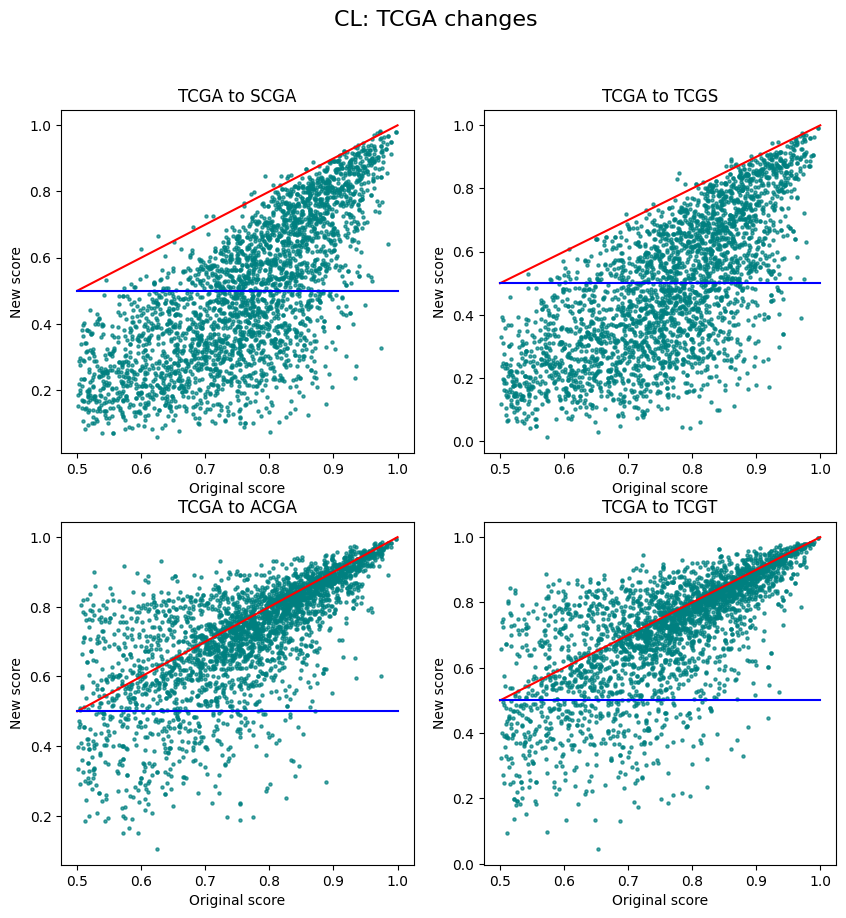

In [55]:
fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = tcga_dict_first["GCGA"] + tcga_dict_first["CCGA"]
a = a / 2
plt.scatter(x=tcga_dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to SCGA" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=tcga_dict_first[original_flank], y=tcga_dict_first["ACGA"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "ACGA"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = tcga_dict_last["TCGG"] + tcga_dict_last["TCGC"]
a = a / 2
plt.scatter(x=tcga_dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to TCGS" % original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=tcga_dict_last[original_flank], y=tcga_dict_last["TCGT"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGT"))
plt.xlabel("Original score")
plt.ylabel("New score")


fig.suptitle('CL: %s changes' % original_flank, fontsize=16)
fig.savefig("./cl_%s_changes_prediction.png" %original_flank)
plt.show()
plt.close()

In [0]:
original_flank = "TCGT"
tcgt_dict_first = calculate_flank_changes_ww_to_ss(tcgt, original_flank)
tcgt_dict_last = calculate_flank_changes_ww_to_ss(tcgt, original_flank, False)


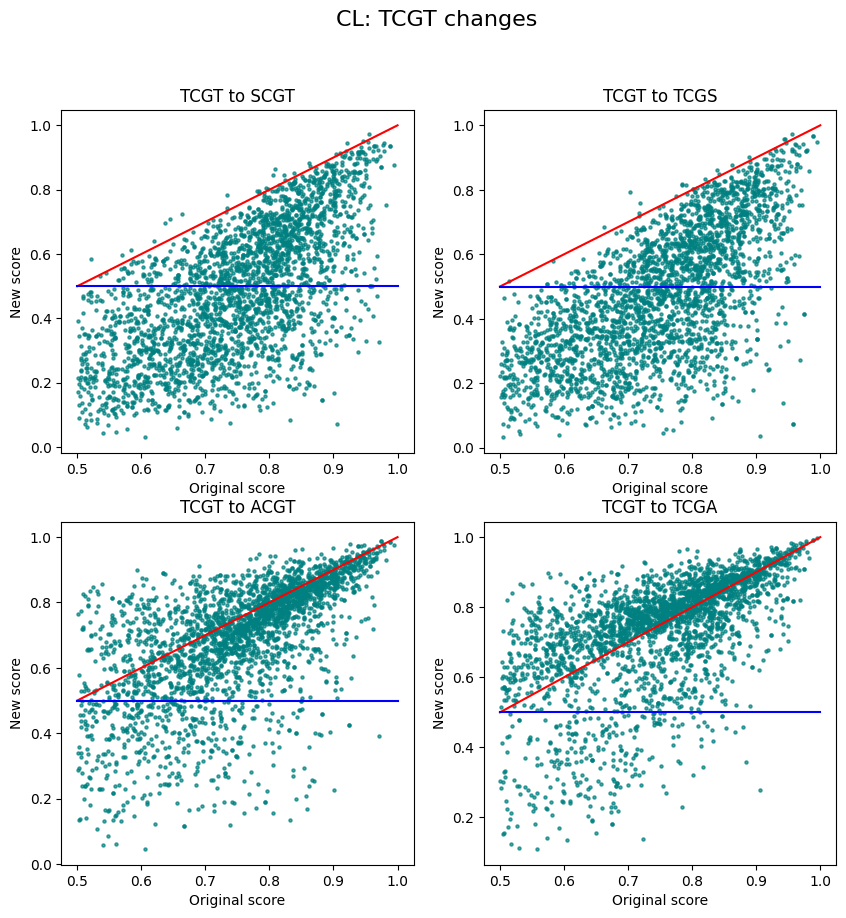

In [57]:
fig = plt.figure(figsize=(10,10), dpi=100)

# First 
# W to S together
ax = fig.add_subplot(221)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = tcgt_dict_first["GCGT"] + tcgt_dict_first["CCGT"]
a = a / 2
plt.scatter(x=tcgt_dict_first[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to SCGT" %original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(223)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=tcgt_dict_first[original_flank], y=tcgt_dict_first["ACGT"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "ACGT"))
plt.xlabel("Original score")
plt.ylabel("New score")


# Second 
# W to S together
ax = fig.add_subplot(222)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")

ax.add_line(line_y_x)
ax.add_line(line_y_05)

a = tcgt_dict_last["TCGG"] + tcgt_dict_last["TCGC"]
a = a / 2
plt.scatter(x=tcgt_dict_last[original_flank], y=a, marker='.', s=20, alpha=0.7, c="teal")
plt.title("%s to TCGS" % original_flank)

plt.xlabel("Original score")
plt.ylabel("New score")


# W to another W
ax = fig.add_subplot(224)
line_y_x = Line2D([0.5,1],[0.5,1], c="r", label = "y=x")
line_y_05 = Line2D([0.5,1],[0.5,0.5], c="b", label = "y=0.5")
ax.add_line(line_y_x)
ax.add_line(line_y_05)
plt.scatter(x=tcgt_dict_last[original_flank], y=tcgt_dict_last["TCGA"], marker='.', s=20, alpha=0.7, c="teal")
# plt.legend()
plt.title("%s to %s" %(original_flank, "TCGA"))
plt.xlabel("Original score")
plt.ylabel("New score")


fig.suptitle('CL: %s changes' % original_flank, fontsize=16)
fig.savefig("./cl_%s_changes_prediction.png" %original_flank)
plt.show()
plt.close()

**Save sequence of predicated correctly **

In [0]:
pred = get_prediction(x_test_seq)

In [0]:
ind = []
for i in range(pred.shape[0]):
  if int(np.round(pred[i])) == y_test[i]:
    ind.append(i)


In [0]:
rel = pred[ind]

In [0]:
with open("./sequence_prediction.pkl", "wb") as f:
  pickle.dump(ar, f)

Change WW to SS total and plot total classificaton kept 

In [0]:
def get_cl_changes(thr):
  # Look at all the CL which are WW and change to SS
  cl_ind = get_ex_ind(CLASS_COMPLETELY_LOSS,thr=thr)
  cl_seq_array = np.array([x_test_seq[i] for i in cl_ind])
  cl_seq = vecs2dna(cl_seq_array)
  cl_ww_seq = [i for i in cl_seq if ww_re.search(i) != None]
  cl_ss_seq = [i for i in cl_seq if ss_re.search(i) !=None]

  cl_ww_to_ss = []
  for seq in cl_ww_seq:
    new_seq = seq[:73] + "CCGC" + seq[77:]
    cl_ww_to_ss.append(new_seq)

    new_seq = seq[:73] + "GCGG" + seq[77:]
    cl_ww_to_ss.append(new_seq)

    new_seq = seq[:73] + "CCGG" + seq[77:]
    cl_ww_to_ss.append(new_seq)

    new_seq = seq[:73] + "GCGC" + seq[77:]
    cl_ww_to_ss.append(new_seq)

  expected = len(cl_ww_to_ss)
  cl_ww_to_ss_arr = np.array([seq_to_mat(i) for i in cl_ww_to_ss])

  pred = get_prediction(cl_ww_to_ss_arr)
  return np.sum(pred>0.5) / expected * 100


In [0]:
thr_to_check = np.arange(0.5,1.0,0.05)
l1 = []
l2 = []

for i in thr_to_check:
  v =i
  l1.append(v)
  l2.append(get_cl_changes(v))

Text(0, 0.5, '% sequences which kept label')

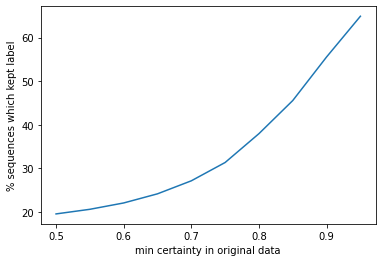

In [0]:
plt.plot(l1,l2)
plt.xlabel("min certainty in original data")
plt.ylabel("% sequences which kept label")

Caclculate CL ww to ss changes and integrated explanation

In [0]:
# len(cl_ss_predicted_cl)
cl_ss_predicted_cl = [cl_ww_to_ss[i] for i in range(pred.shape[0]) if pred[i] > 0.75] + cl_ss_seq
cl_ex_seq = get_ex_seq(np.array([seq_to_mat(i) for i in cl_ss_predicted_cl]),predict_label=CLASS_COMPLETELY_LOSS, number_of_seq=-1, thr=0.75)

In [0]:
# Look at all the PL which are SS and change to WW
pl_ind = get_ex_ind(CLASS_PARTIAL_LOSS, thr=0.75)
pl_seq_array = np.array([x_test_seq[i] for i in pl_ind])

pl_seq = vecs2dna(pl_seq_array)
pl_ww_seq = [i for i in pl_seq if ww_re.search(i) != None]
pl_ss_seq = [i for i in pl_seq if ss_re.search(i) !=None]

pl_ss_to_ww = []
for seq in pl_ss_seq:
  new_seq = seq[:73] + "ACGA" + seq[77:]
  pl_ss_to_ww.append(new_seq)

  new_seq = seq[:73] + "ACGT" + seq[77:]
  pl_ss_to_ww.append(new_seq)

  new_seq = seq[:73] + "TCGT" + seq[77:]
  pl_ss_to_ww.append(new_seq)

  new_seq = seq[:73] + "TCGA" + seq[77:]
  pl_ss_to_ww.append(new_seq)

expected = len(pl_ss_to_ww)
pl_ww_to_ss_arr = np.array([seq_to_mat(i) for i in pl_ss_to_ww])

pred = 1 - get_prediction(pl_ww_to_ss_arr)
np.sum(pred>0.5) / expected * 100

43.34658078662464

In [0]:
# len(cl_ss_predicted_cl)
pl_ww_predicted_pl = [pl_ss_to_ww[i] for i in range(pred.shape[0]) if pred[i] > 0.75] + pl_ww_seq
pl_ex_seq = get_ex_seq(np.array([seq_to_mat(i) for i in pl_ww_predicted_pl]),predict_label=CLASS_PARTIAL_LOSS, number_of_seq=-1, thr=0.75)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [0]:
import pickle

d = {"cl": cl_ex_seq, "pl": pl_ex_seq}

with open("./gradients_explain/kept_prediction_after_changes_1_flank.pkl", "wb") as f:
  pickle.dump(d, f)

Info on reverse strand 

In [0]:
TRANSLATION_TABLE = {84: 65, 65: 84, 67: 71, 71: 67}
pred = get_prediction(x_test_seq)


In [0]:
sequences = vecs2dna(x_test_seq)

TypeError: ignored

In [0]:
import pandas as pd
df = pd.DataFrame()

In [0]:
df["seq"] = sequences
df["pred"] = pred

In [0]:
gb = df.groupby("seq").mean()

In [0]:
values_d = {}
for seq in gb.index:
  reversed_seq = seq.translate(TRANSLATION_TABLE)[::-1] 
  if reversed_seq in values_d:
    continue
  
  values_d[seq] = (gb[gb.index == seq]["pred"][0], gb[gb.index ==reversed_seq]["pred"][0])

In [0]:
a = [i[0] for i in values_d.values()]
b = [i[1] for i in values_d.values()]

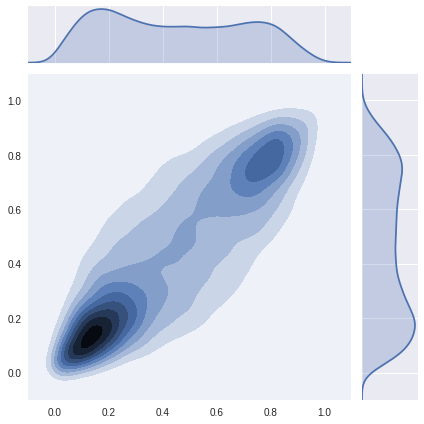

In [281]:
sns.jointplot(x=a, y=b, kind='kde')

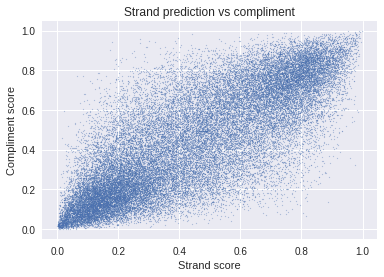

In [287]:
plt.scatter(a,b, marker='o', s=1, alpha=0.3)
plt.title("Strand prediction vs compliment")
plt.xlabel("Strand score")
plt.ylabel("Compliment score")
plt.show()